**Imports**

In [1]:
# OS utilities
import os

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text processing
import string
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords

# Data analysis
from collections import Counter

# Download NLTK stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ipantelidis/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Data Loading**

In [2]:
data_path = "/media/SSD_2TB/imageclef2025/imageclef2025/development_caption_prediction"

In [3]:
train_captions = pd.read_csv(os.path.join(data_path, 'train_captions.csv'))
valid_captions = pd.read_csv(os.path.join(data_path, 'valid_captions.csv'))

In [4]:
print(f"\nInitial dataset sizes for the caption prediction task:")  
print(f"  - Training set: {len(train_captions)} samples")  
print(f"  - Validation set: {len(valid_captions)} samples")  


Initial dataset sizes for the caption prediction task:
  - Training set: 80091 samples
  - Validation set: 17277 samples


In [5]:
captions_dataset = pd.concat([train_captions, valid_captions]).reset_index(drop=True)

In [6]:
print(f"\nCombined dataset size for the caption prediction task:")  
print(f"  - Training + Validation set: {len(captions_dataset)} samples")  


Combined dataset size for the caption prediction task:
  - Training + Validation set: 97368 samples


**1) Dataset Inspection**

In [7]:
captions_dataset.head()

,ImageCLEFmedical 2025 ID,Caption
0,ImageCLEFmedical_Caption_2025_train_0,Head CT demonstrating left parotiditis.
1,ImageCLEFmedical_Caption_2025_train_1,Chest X-ray showing enlarged cardiac silhouett...
2,ImageCLEFmedical_Caption_2025_train_2,CT chest axial view showing a huge ascending a...
3,ImageCLEFmedical_Caption_2025_train_3,Acquired renal cysts in end-stage renal failur...
4,ImageCLEFmedical_Caption_2025_train_4,Computed tomography (CT) shows floating thromb...


In [8]:
captions_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97368 entries, 0 to 97367
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ImageCLEFmedical 2025 ID  97368 non-null  object
 1   Caption                   97368 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


**2) Basic Statistics of the Caption Column**

In [9]:
# Count unique captions
num_unique_captions = captions_dataset["Caption"].nunique()
print(f"Number of unique captions: {num_unique_captions}\n")

Number of unique captions: 96866



In [10]:
# Percentage unique captions
percentage_unique_captions = (num_unique_captions / len(captions_dataset)) * 100
print(f"Percentage of unique captions: {percentage_unique_captions:.2f}%")

Percentage of unique captions: 99.48%


In [11]:
# Caption length statistics
captions_dataset["Caption Length"] = captions_dataset["Caption"].apply(lambda x: len(x.split()))
print(captions_dataset["Caption Length"].describe()) 

count    97368.000000
mean        21.044347
std         16.544003
min          1.000000
25%         11.000000
50%         17.000000
75%         26.000000
max        778.000000
Name: Caption Length, dtype: float64


In [12]:
min_length = captions_dataset["Caption Length"].min()
min_length_count = (captions_dataset["Caption Length"] == min_length).sum()

print(f"The minimum caption length encountered is {min_length}, occurring {min_length_count} times.")

The minimum caption length encountered is 1, occurring 81 times.


In [13]:
max_length = captions_dataset["Caption Length"].max()
max_length_count = (captions_dataset["Caption Length"] == max_length).sum()

print(f"The maximum caption length encountered is {max_length}, occurring {max_length_count} times.")

The maximum caption length encountered is 778, occurring 1 times.


**3) Visualizing Caption Length Distribution**

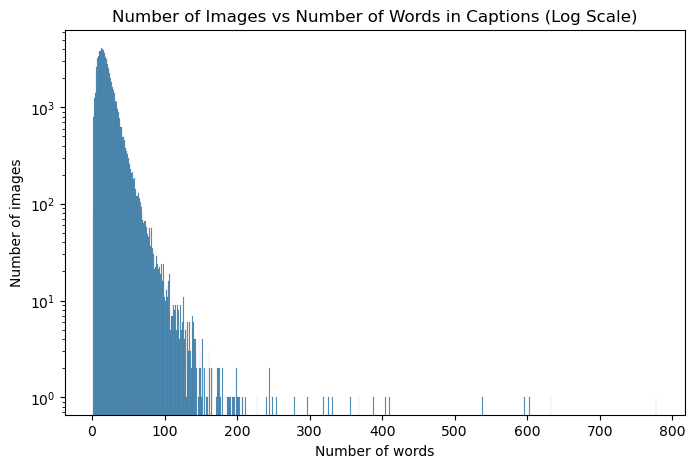

In [14]:
plt.figure(figsize=(8, 5))
sns.histplot(captions_dataset["Caption Length"], bins=max_length)
plt.yscale("log") 
plt.xlabel("Number of words")
plt.ylabel("Number of images")
plt.title("Number of Images vs Number of Words in Captions (Log Scale)")
plt.xticks(np.arange(0, 900, 100)) 
plt.show()

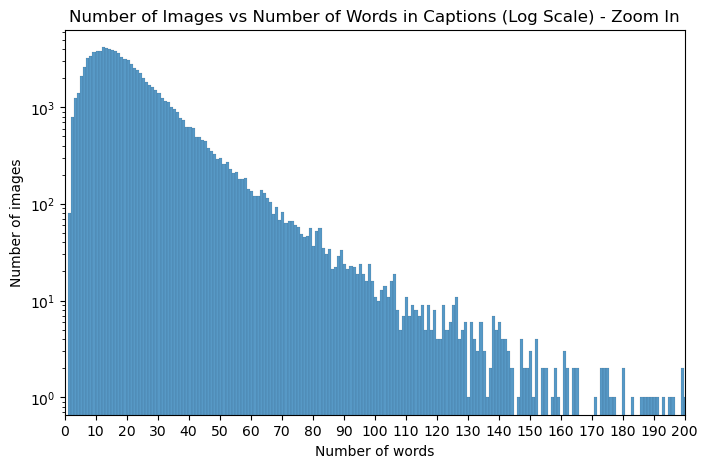

In [19]:
plt.figure(figsize=(8, 5))
sns.histplot(captions_dataset["Caption Length"], bins=max_length)
plt.xlim(0, 200)
plt.yscale("log") 
plt.xlabel("Number of words")
plt.ylabel("Number of images")
plt.title("Number of Images vs Number of Words in Captions (Log Scale) - Zoom In")
plt.xticks(np.arange(0, 201, 10)) 
plt.show()

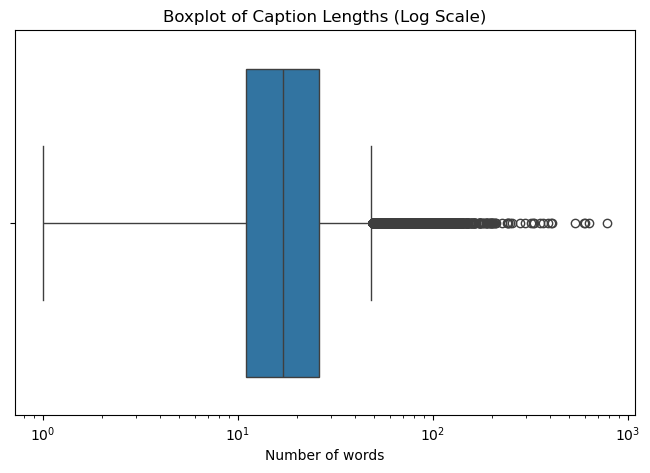

In [14]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=captions_dataset["Caption Length"])
plt.xscale("log") 
plt.xlabel("Number of words")
plt.title("Boxplot of Caption Lengths (Log Scale)")
plt.show()

**4) Most Common and Rare Captions**

In [15]:
# Most common captions
print("Most common captions:")
print(captions_dataset["Caption"].value_counts().head(10))

Most common captions:
Caption
Initial panoramic radiograph.         41
Final panoramic radiograph.           37
Chest X-ray.                          21
Chest radiograph.                     17
Chest X-ray                           11
Pretreatment panoramic radiograph.    10
Preoperative panoramic radiograph.    10
Preoperative CT scan.                 10
Video Link:                            9
Chest X-ray on admission.              9
Name: count, dtype: int64


In [16]:
# Least common captions (rare ones)
print("\nLeast common captions:")
print(captions_dataset["Caption"].value_counts().tail(10))


Least common captions:
Caption
X-ray tuberculosis.Probable cavity in the right lung apex with evidence of consolidation.                                                                                                                                        1
Initial chest radiologic findings show elevated right diaphragm (white arrows).                                                                                                                                                  1
Axial View Showing the Prevalence of Septa on the Left Side                                                                                                                                                                      1
Axial View Showing the Location of PSAA on the Left and Right Sides of the Maxillary SinusPSAA: posterior superior alveolar artery                                                                                               1
Panoramic View Showing Course of PSAA on Left and Right Side

**5) Most Common Words (Excluding Stopwords)**

In [18]:
# Tokenize and clean text
def clean_text(text):
    tokens = text.lower().translate(str.maketrans("", "", string.punctuation)).split()
    return [word for word in tokens if word not in stop_words]

# Flatten the list of words
all_words = [word for caption in captions_dataset["Caption"] for word in clean_text(caption)]

# Get most common words
word_counts = Counter(all_words)
most_common_words = word_counts.most_common(10)

print("Top 10 Most Common Words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

Top 10 Most Common Words:
showing: 27418
arrow: 23065
right: 22782
left: 22622
ct: 21360
image: 14109
chest: 12865
tomography: 12489
scan: 12266
computed: 11184


**6) Word Cloud Visualization**

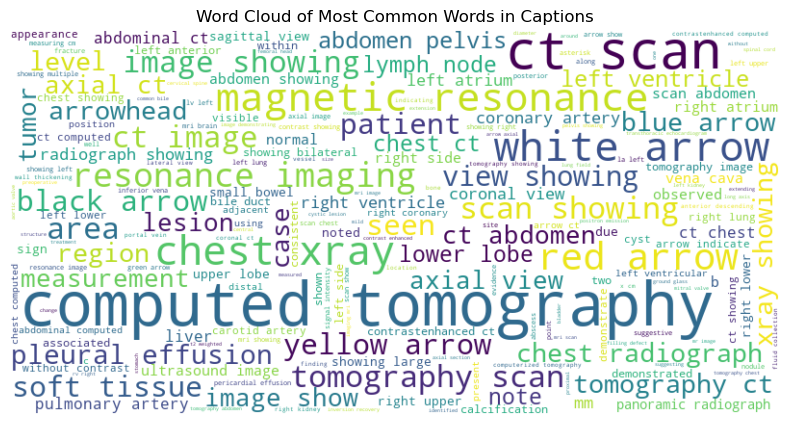

In [19]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Most Common Words in Captions")
plt.show()

**7) N-gram Analysis (Bigram and Trigram Frequencies)**

In [20]:
# Generate bigrams
bigrams = list(ngrams(all_words, 2))
bigram_counts = Counter(bigrams)
most_common_bigrams = bigram_counts.most_common(10)

print("Top 10 Most Common Bigrams:")
for bigram, count in most_common_bigrams:
    print(f"{' '.join(bigram)}: {count}")

Top 10 Most Common Bigrams:
computed tomography: 10539
ct scan: 7381
chest xray: 4148
magnetic resonance: 4027
white arrow: 3328
red arrow: 2842
resonance imaging: 2836
tomography scan: 2292
scan showing: 2275
image showing: 2174


In [21]:
# Generate trigrams
trigrams = list(ngrams(all_words, 3))
trigram_counts = Counter(trigrams)
most_common_trigrams = trigram_counts.most_common(10)

print("Top 10 Most Common Trigrams:")
for trigram, count in most_common_trigrams:
    print(f"{' '.join(trigram)}: {count}")

Top 10 Most Common Trigrams:
magnetic resonance imaging: 2777
computed tomography scan: 2042
computed tomography ct: 1444
ct scan showing: 1357
chest xray showing: 1041
ct scan abdomen: 767
ct computed tomography: 749
chest computed tomography: 691
abdominal computed tomography: 682
computed tomography image: 633


**8) Checking for Special Cases**

In [22]:
# Shortest captions
print("Shortest captions:")
print(captions_dataset.loc[captions_dataset["Caption Length"] == captions_dataset["Caption Length"].min(), "Caption"])

Shortest captions:
28                   Hypotelorism.
633                   Splenomegaly
2059     Diagnostic/investigations
2115                           CT.
2734              Orthopantomogram
                   ...            
85414                    Continued
87859             Orthopantomogram
89125                Cholangiogram
89271            Echocardiography.
94141            Pneumomediastinum
Name: Caption, Length: 81, dtype: object


In [23]:
# Longest captions
print("\nLongest captions:")
print(captions_dataset.loc[captions_dataset["Caption Length"] == captions_dataset["Caption Length"].max(), "Caption"])


Longest captions:
18531    Point-of-care ultrasonography image demonstrat...
Name: Caption, dtype: object
